# Making predictions with logistic regression

In [1]:
# prep: import modules and get pwd
import matplotlib.pyplot as plt
import seaborn as sns 
import math
from sklearn import linear_model
import numpy as np
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
SELECT
    f.title AS film_name,
    c.name AS category,
    f.rental_duration,
    f.rental_rate,
    f.length,
    f.rating
FROM sakila.film f
JOIN sakila.film_category fc USING(film_id)
JOIN sakila.category c USING(category_id)
ORDER BY title;
'''

data = pd.read_sql_query(query, engine)
data

,film_name,category,rental_duration,rental_rate,length,rating
0,ACADEMY DINOSAUR,Documentary,6,0.99,86,PG
1,ACE GOLDFINGER,Horror,3,4.99,48,G
2,ADAPTATION HOLES,Documentary,7,2.99,50,NC-17
3,AFFAIR PREJUDICE,Horror,5,2.99,117,G
4,AFRICAN EGG,Family,6,2.99,130,G
...,...,...,...,...,...,...
995,YOUNG LANGUAGE,Documentary,6,0.99,183,G
996,YOUTH KICK,Music,4,0.99,179,NC-17
997,ZHIVAGO CORE,Horror,6,0.99,105,NC-17
998,ZOOLANDER FICTION,Children,5,2.99,101,R


In [3]:
query = '''
SELECT
    f.title,
    MAX(CASE WHEN (r.rental_date IS NULL) OR (r.rental_date >= '2005-05-01' AND r.rental_date < '2005-06-01') THEN 1 ELSE 0 END) AS rented_in_may
FROM
    film f
LEFT JOIN
    inventory i ON f.film_id = i.film_id
LEFT JOIN
    rental r ON i.inventory_id = r.inventory_id
GROUP BY
    f.title;
'''

rented_in_may = pd.read_sql_query(query, engine)

rented_in_may

,title,rented_in_may
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1
...,...,...
995,YOUNG LANGUAGE,0
996,YOUTH KICK,0
997,ZHIVAGO CORE,1
998,ZOOLANDER FICTION,1


In [4]:
rented_in_may['rented_in_may'].value_counts()

rented_in_may
1    728
0    272
Name: count, dtype: int64

In [5]:
may_data = pd.concat([data,rented_in_may['rented_in_may']], axis = 1)
may_data

,film_name,category,rental_duration,rental_rate,length,rating,rented_in_may
0,ACADEMY DINOSAUR,Documentary,6,0.99,86,PG,1
1,ACE GOLDFINGER,Horror,3,4.99,48,G,0
2,ADAPTATION HOLES,Documentary,7,2.99,50,NC-17,1
3,AFFAIR PREJUDICE,Horror,5,2.99,117,G,1
4,AFRICAN EGG,Family,6,2.99,130,G,1
...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,Documentary,6,0.99,183,G,0
996,YOUTH KICK,Music,4,0.99,179,NC-17,0
997,ZHIVAGO CORE,Horror,6,0.99,105,NC-17,1
998,ZOOLANDER FICTION,Children,5,2.99,101,R,1


In [6]:
may_data.isna().sum()

film_name          0
category           0
rental_duration    0
rental_rate        0
length             0
rating             0
rented_in_may      0
dtype: int64

In [7]:
numerical_columns = may_data.select_dtypes(include='number').columns
correlations_matrix = may_data[numerical_columns].corr()
correlations_matrix

,rental_duration,rental_rate,length,rented_in_may
rental_duration,1.000000,0.025777,0.061586,-0.044724
rental_rate,0.025777,1.000000,0.029789,-0.017371
length,0.061586,0.029789,1.000000,-0.001058
rented_in_may,-0.044724,-0.017371,-0.001058,1.000000


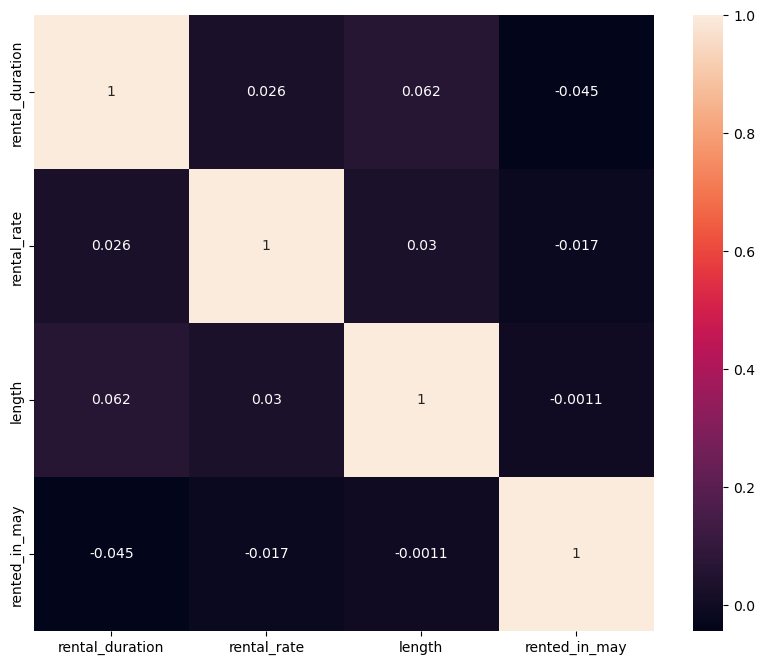

In [8]:
fig, ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(correlations_matrix, annot=True)
plt.show()

# Xy Split

In [9]:
y = may_data['rented_in_may']
X = may_data.drop(['rental_duration', 'length', 'rental_rate'], axis=1)

# Train-Test Split

In [10]:
X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 4)
(200, 4)
(800,)
(200,)


# Encoding categorical variables

In [13]:
X_cat

,film_name,category,rating
0,ACADEMY DINOSAUR,Documentary,PG
1,ACE GOLDFINGER,Horror,G
2,ADAPTATION HOLES,Documentary,NC-17
3,AFFAIR PREJUDICE,Horror,G
4,AFRICAN EGG,Family,G
...,...,...,...
995,YOUNG LANGUAGE,Documentary,G
996,YOUTH KICK,Music,NC-17
997,ZHIVAGO CORE,Horror,NC-17
998,ZOOLANDER FICTION,Children,R


In [14]:
X_cat = X_cat.drop(['film_name'], axis=1)
X_cat

,category,rating
0,Documentary,PG
1,Horror,G
2,Documentary,NC-17
3,Horror,G
4,Family,G
...,...,...
995,Documentary,G
996,Music,NC-17
997,Horror,NC-17
998,Children,R


In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(X_cat)
X_cat_encode = pd.DataFrame(encoder.transform(X_cat).toarray(), columns=encoder.get_feature_names_out(input_features=X_cat.columns))
X_cat_encoded = pd.concat([X_cat, X_cat_encode], axis=1)
display(X_cat_encoded)


,category,rating,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,...,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,Documentary,PG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Horror,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Documentary,NC-17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Horror,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Family,G,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Documentary,G,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,Music,NC-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
997,Horror,NC-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
998,Children,R,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_cat_encoded, y, test_size=0.2)
print("X_train_cat shape:", X_train_cat.shape)
print("X_test_cat shape:", X_test_cat.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_cat shape: (800, 21)
X_test_cat shape: (200, 21)
y_train shape: (800,)
y_test shape: (200,)


# Scaling numerical values

In [17]:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object)

X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes(object)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(transformer.transform(X_train_num), columns=X_train_num.columns)
X_train_scaled

,rented_in_may
0,0.612022
1,0.612022
2,-1.633929
3,0.612022
4,0.612022
...,...
795,-1.633929
796,0.612022
797,0.612022
798,0.612022


In [19]:
X_test_num = X_test.select_dtypes(np.number)
X_test_scaled = pd.DataFrame(transformer.transform(X_test_num), columns=X_test_num.columns)
X_test_scaled

,rented_in_may
0,0.612022
1,0.612022
2,-1.633929
3,-1.633929
4,0.612022
...,...
195,0.612022
196,0.612022
197,0.612022
198,-1.633929


In [20]:
# Assuming X_train_scaled, X_train_cat, X_test_scaled, and X_test_cat are defined
# Concatenate scaled numerical and categorical features for both training and testing sets

X_train = pd.concat([X_train_scaled, X_train_cat], axis=1)
X_test = pd.concat([X_test_scaled, X_test_cat], axis=1)


In [21]:
X_train

,rented_in_may,film_name,category,rating
0,0.612022,ACADEMY DINOSAUR,Documentary,PG
1,0.612022,ACE GOLDFINGER,Horror,G
2,-1.633929,NaN,NaN,NaN
3,0.612022,NaN,NaN,NaN
4,0.612022,NaN,NaN,NaN
...,...,...,...,...
816,NaN,SOLDIERS EVOLUTION,Sci-Fi,R
880,NaN,TEMPLE ATTRACTION,Horror,PG
986,NaN,WORDS HUNTER,Music,PG
860,NaN,SUIT WALLS,Games,R


In [22]:
print(X_train.isnull().sum())

rented_in_may    173
film_name        173
category         173
rating           173
dtype: int64


# Logistic regression model

In [23]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train_scaled, y_train)

LogisticRegression()

In [24]:
LR.predict_proba(X_train_scaled)

array([[0.26293084, 0.73706916],
       [0.26293084, 0.73706916],
       [0.28887267, 0.71112733],
       ...,
       [0.26293084, 0.73706916],
       [0.26293084, 0.73706916],
       [0.28887267, 0.71112733]])

In [25]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train_scaled, y_train)
LR.score(X_test_scaled, y_test)

0.72

In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.72
recall:  1.0
f1:  0.8372093023255813
